## This notebook is same as devign-fix.ipynb - It just compute word2vec and plot embedding instead of training

In [2]:
import configs, gc, pickle
from tabulate import tabulate
import pandas as pd
import numpy as np
import networkx as nx
import src.data as data_util
from src.utils.functions.parse import tokenizer
import torch
from gensim.models.word2vec import Word2Vec
from torch_geometric.data import Data
from torch_geometric.utils import convert
from gensim.models.keyedvectors import Word2VecKeyedVectors
import pathlib, glob, os, time, re, json
from pathlib import Path
from tqdm.auto import tqdm
import pygraphviz
import scipy.sparse as sp
from gensim.models.word2vec import Word2Vec
from src.utils.functions.parse import tokenizer
import src.data as data_util
import src.process as process
import matplotlib.pyplot as plt



%matplotlib inline

In [3]:
class NodesEmbedding:
    def __init__(self, nodes_dim: int, w2v_keyed_vectors: Word2VecKeyedVectors):
        self.w2v_keyed_vectors = w2v_keyed_vectors
        self.kv_size = w2v_keyed_vectors.vector_size
        self.nodes_dim = nodes_dim

        assert self.nodes_dim >= 0

        # Buffer for embeddings with padding
        self.target = torch.zeros(self.nodes_dim, self.kv_size).float()

    def __call__(self, nodes):
        embedded_nodes = self.embed_nodes(nodes)

        nodes_tensor = torch.from_numpy(embedded_nodes).float()

        self.target[:nodes_tensor.size(0), :] = nodes_tensor

        return self.target

    def embed_nodes(self, G):
        embeddings = []

        for (n,d) in G.nodes(data=True):
            # Get node's code
            node_code = d
            # Tokenize the code
            tokenized_code = tokenizer("".join(d.values()))
            if not tokenized_code:
                # print(f"Dropped node {node}: tokenized code is empty.")
                msg = f"Empty TOKENIZED from node CODE {node_code}"
                print(msg)
            # Get each token's learned embedding vector
            vectorized_code = np.array(self.get_vectors(tokenized_code))
            # The node's source embedding is the average of it's embedded tokens
            source_embedding = np.mean(vectorized_code, 0)
            # The node representation is the concatenation of label and source embeddings
            #embedding = np.concatenate((np.array([node.type]), source_embedding), axis=0)
            embeddings.append(source_embedding)
        # print(node.label, node.properties.properties.get("METHOD_FULL_NAME"))

        return np.array(embeddings)

    # fromTokenToVectors
    def get_vectors(self, tokenized_code):
        vectors = []
        for token in tokenized_code:
            if token in self.w2v_keyed_vectors.key_to_index:
                vectors.append(self.w2v_keyed_vectors[token])
            else:
                # print(node.label, token, node.get_code(), tokenized_code)
                vectors.append(np.zeros(self.kv_size))
        return vectors



def nodes_to_input(G, target, nodes_dim, keyed_vectors):
    nodes_embedding = NodesEmbedding(nodes_dim, keyed_vectors)
    edge_index, edge_attr = convert.from_scipy_sparse_matrix(nx.adjacency_matrix(G))
    label = torch.tensor([target]).float()

    return Data(x=nodes_embedding(G), edge_index=edge_index, edge_attr=edge_attr ,y=label)

In [63]:
data = pd.read_pickle('cfg_data.pkl')
data = data[(data['is_connected']==True) & (np.array([G.number_of_nodes()>0 for G in data['graph'].values]))]
data = data[['target', 'project', 'graph','func_code']]
data = data.rename(columns={'func_code': 'func'})
data['project'].unique()

array(['qemu', 'FFmpeg'], dtype=object)

In [67]:
data.head()

,target,project,graph,func
index,,,,
1351,0,qemu,"(1000104, 1000108, 1000113, 1000114, 1000117, ...",static uint32_t s390_pci_generate_fid(Error **...
2903,0,qemu,"(1000107, 1000109, 1000111, 1000117, 1000123, ...","static int hdev_open(BlockDriverState *bs, con..."
5323,1,qemu,"(1000108, 1000111, 1000113, 1000115, 1000117, ...",static void test_media_insert(void)\n\n{\n\n ...
10901,1,qemu,"(1000109, 1000111, 1000114, 1000119, 1000121, ...",static void ivshmem_common_realize(PCIDevice *...
5657,0,qemu,"(1000105, 1000106, 1000107, 1000108, 1000110, ...","static int v9fs_do_lstat(V9fsState *s, V9fsStr..."


In [77]:
new_data      = data[data['project']=='FFmpeg']
new_data_mask = new_data.apply(lambda g: nx.number_of_nodes(g.graph), axis=1)>10
new_data      = new_data[new_data_mask]

In [78]:
print("No of samples in dataset: {} ".format(len(new_data)))
print('Complete dataset stats')
print('\n'*3,'Complete dataset stats\n',"*"*40,'\n')

node_size_group = new_data.apply(lambda g: nx.number_of_nodes(g.graph),axis=1).describe()[['min', 'max','mean','std']]

print(tabulate(node_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Node stats']))


print('\n'*3)

edge_size_group = new_data.apply(lambda g: nx.number_of_edges(g.graph),axis=1).describe()[['min', 'max','mean','std']]
print(tabulate(edge_size_group.to_frame(),
                   tablefmt="grid", stralign='left', numalign='left',
                   headers=['Edge stats']))

print('\n\n')
print('Stats for each class')
print("1 = Vulnerable, 0 = Not Vulnerable")
print('\n')
for name, group in new_data.groupby('target'):
    print("No of samples in dataset for class {}: {} ".format(name,len(group)))
    edge_size_group = group.apply(lambda g: nx.number_of_edges(g.graph),axis=1).describe()[['min', 'max','mean','std']]
    node_size_group = group.apply(lambda g: nx.number_of_nodes(g.graph),axis=1).describe()[['min', 'max','mean','std']]
    
    print(tabulate(node_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Class {} Node stats'.format(name)]))
    
    print('\n'*3)
    print(tabulate(edge_size_group.to_frame(),
                   tablefmt="grid", stralign='left', numalign='left',
                   headers=['Class {} Edge stats'.format(name)]))
    print('\n'*3)

No of samples in dataset: 8820 
Complete dataset stats



 Complete dataset stats
 **************************************** 

+------+--------------+
|      | Node stats   |
+======+==============+
| min  | 11           |
+------+--------------+
| max  | 2659         |
+------+--------------+
| mean | 158.742      |
+------+--------------+
| std  | 213.843      |
+------+--------------+




+------+--------------+
|      | Edge stats   |
+======+==============+
| min  | 10           |
+------+--------------+
| max  | 2864         |
+------+--------------+
| mean | 176.041      |
+------+--------------+
| std  | 239.216      |
+------+--------------+



Stats for each class
1 = Vulnerable, 0 = Not Vulnerable


No of samples in dataset for class 0: 4292 
+------+----------------------+
|      | Class 0 Node stats   |
+======+======================+
| min  | 11                   |
+------+----------------------+
| max  | 2117                 |
+------+----------------------+
| mean | 161.

In [79]:
new_data      = data[data['project']=='qemu']
new_data_mask = new_data.apply(lambda g: nx.number_of_nodes(g.graph), axis=1)>10
new_data      = new_data[new_data_mask]

In [80]:
print("No of samples in dataset: {} ".format(len(new_data)))
print('Complete dataset stats')
print('\n'*3,'Complete dataset stats\n',"*"*40,'\n')

node_size_group = new_data.apply(lambda g: nx.number_of_nodes(g.graph),axis=1).describe()[['min', 'max','mean','std']]

print(tabulate(node_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Node stats']))


print('\n'*3)

edge_size_group = new_data.apply(lambda g: nx.number_of_edges(g.graph),axis=1).describe()[['min', 'max','mean','std']]
print(tabulate(edge_size_group.to_frame(),
                   tablefmt="grid", stralign='left', numalign='left',
                   headers=['Edge stats']))

print('\n\n')
print('Stats for each class')
print("1 = Vulnerable, 0 = Not Vulnerable")
print('\n')
for name, group in new_data.groupby('target'):
    print("No of samples in dataset for class {}: {} ".format(name,len(group)))
    edge_size_group = group.apply(lambda g: nx.number_of_edges(g.graph),axis=1).describe()[['min', 'max','mean','std']]
    node_size_group = group.apply(lambda g: nx.number_of_nodes(g.graph),axis=1).describe()[['min', 'max','mean','std']]
    
    print(tabulate(node_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Class {} Node stats'.format(name)]))
    
    print('\n'*3)
    print(tabulate(edge_size_group.to_frame(),
                   tablefmt="grid", stralign='left', numalign='left',
                   headers=['Class {} Edge stats'.format(name)]))
    print('\n'*3)

No of samples in dataset: 14102 
Complete dataset stats



 Complete dataset stats
 **************************************** 

+------+--------------+
|      | Node stats   |
+======+==============+
| min  | 11           |
+------+--------------+
| max  | 4648         |
+------+--------------+
| mean | 73.1254      |
+------+--------------+
| std  | 146.188      |
+------+--------------+




+------+--------------+
|      | Edge stats   |
+======+==============+
| min  | 10           |
+------+--------------+
| max  | 12099        |
+------+--------------+
| mean | 86.1872      |
+------+--------------+
| std  | 239.253      |
+------+--------------+



Stats for each class
1 = Vulnerable, 0 = Not Vulnerable


No of samples in dataset for class 0: 8083 
+------+----------------------+
|      | Class 0 Node stats   |
+======+======================+
| min  | 11                   |
+------+----------------------+
| max  | 4648                 |
+------+----------------------+
| mean | 72.

In [9]:
def w2v_feature(dataset: str, sample_size=100):
    if dataset not in ['qemu','FFmpeg']:
        print('dataset should be either one of', ['qemu','FFmpeg'])
        return
    data1 = data[data['project']==dataset]
    print('Tokenizing source code')
    tokens_dataset = data_util.tokenize(data1)

    #you can change here that instead of training word2vec again load the available dataset
    print('Training word2vec on tokens')
    w2vmodel = Word2Vec(sentences=tokens_dataset.tokens, vector_size=200, window=5, min_count=1, workers=4, epochs=10)
    print('Converting tokens to word2vec representation')

    data1["input"] = data1.apply(lambda row: nodes_to_input(row.graph, row.target, nx.number_of_nodes(row.graph),
                                                                                    w2vmodel.wv), axis=1)
    data1_100 = data1[data1['target']==1].sample(sample_size)
    data0_100 = data1[data1['target']==0].sample(sample_size)

    arr1 = np.array([np.array(x.x.sum(axis=0)) for x in data1_100['input'].values]).flatten()
    arr0 = np.array([np.array(x.x.sum(axis=0)) for x in data0_100['input'].values]).flatten()
    
    fig, axs = plt.subplots(3, figsize =(15,20))
    #fig.suptitle('Vertically stacked subplots')
    axs[0].plot(arr1, label='True', color='blue')
    axs[0].plot(arr0, label='False', color='orange')
    axs[0].set_ylabel('Value of w2v vectors')
    axs[0].set_title('Positive and negative')
    axs[0].legend()
    axs[1].plot(arr0, label='False', color='orange')
    axs[1].set_title('Positive')
    axs[1].legend()
    axs[2].plot(arr1, label='True',color='blue')
    axs[2].set_title('Negative')
    axs[2].legend()

## Qemu 

Tokenizing source code


/home/ammar/vuln_code/vuln_env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Training word2vec on tokens code
Converting tokens to word2vec representation


/tmp/ipykernel_3855781/2170042467.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1["input"] = data1.apply(lambda row: nodes_to_input(row.graph, row.target, nx.number_of_nodes(row.graph),


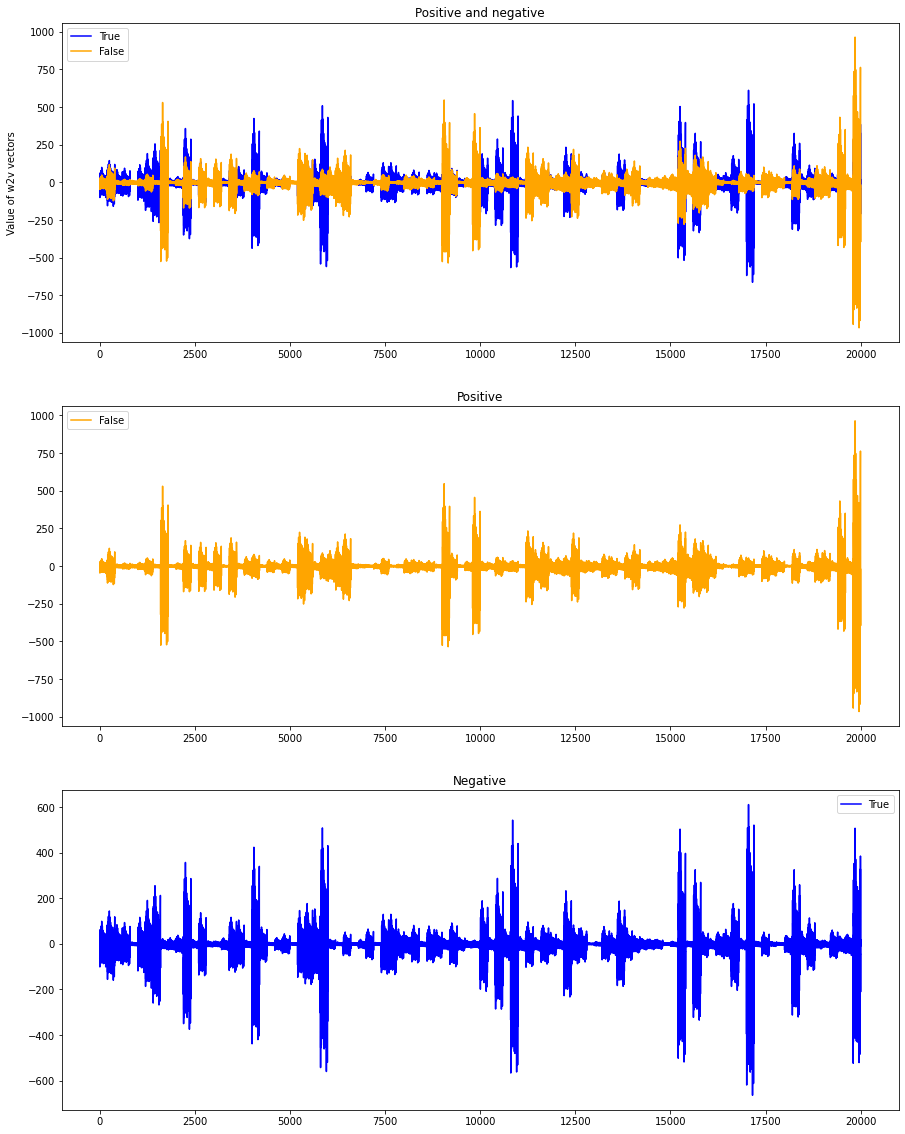

In [10]:
w2v_feature('qemu', sample_size=100)

## FFmpeg

Tokenizing source code


/home/ammar/vuln_code/vuln_env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Training word2vec on tokens code
Converting tokens to word2vec representation


/tmp/ipykernel_3855781/2170042467.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1["input"] = data1.apply(lambda row: nodes_to_input(row.graph, row.target, nx.number_of_nodes(row.graph),


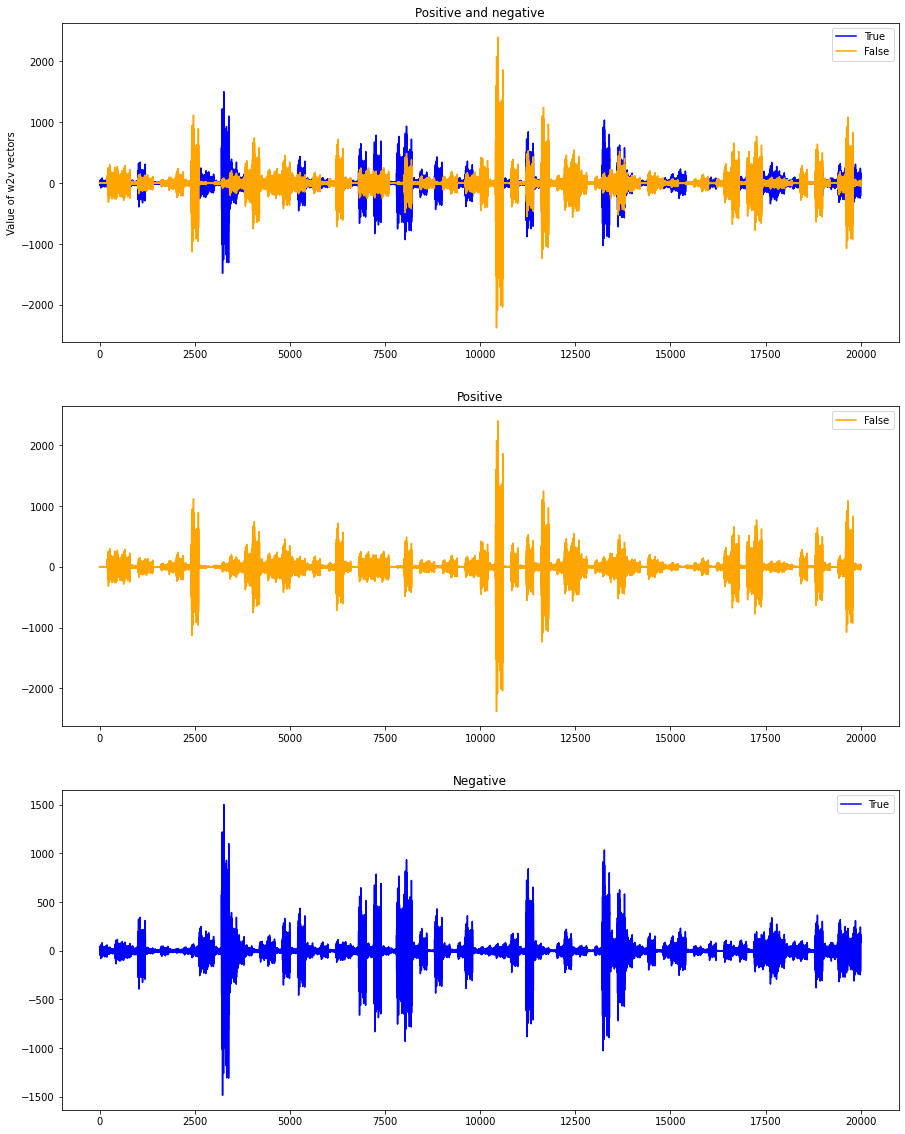

In [11]:
w2v_feature('FFmpeg', sample_size=100)

## Reading all the new data and training a word2vec model on it

In [12]:
del data

In [19]:
new_data  = pd.read_csv('msr/MSR_data_cleaned.csv')

In [21]:
new_data_source = pd.DataFrame(data={'func':pd.concat([new_data['func_before'], new_data['func_after']])}) 

In [11]:
tokens_dataset = data_util.tokenize(new_data_source[0:100])

/home/ammar/vuln_code/vuln_env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [15]:
#print(new_data_source.iloc[0].values[0])
#tokens_dataset.iloc[0].values

array([list(['static', 'bool', 'FUN1', '(', 'struct', 'ldb_message', '*', 'VAR1', ')', '{', 'uint32_t', 'VAR2', ',', 'VAR3', ',', 'VAR4', ';', 'VAR2', '=', 'FUN2', '(', 'VAR1', ',', ',', '0', ')', ';', 'VAR3', '=', 'FUN2', '(', 'VAR1', ',', ',', '0', ')', ';', 'VAR4', '=', '(', 'VAR5', '|', 'VAR6', ')', ';', 'if', '(', '(', 'VAR2', '&', 'VAR7', ')', '&&', '(', '(', 'VAR3', '&', 'VAR4', ')', '==', 'VAR4', ')', ')', '{', 'return', 'true', ';', '}', 'else', '{', 'return', 'false', ';', '}', '}'])],
      dtype=object)

In [29]:
#w2vmodel = Word2Vec.load('msr/all_w2v_model_devign_tokens.model')
#for i in (tokens_dataset.iloc[0].values:
#w2vmodel.wv['(']

In [25]:
print('Tokenizing source code')
tokens_dataset = data_util.tokenize(new_data_source)

#you can change here that instead of training word2vec again load the available dataset
print('Training word2vec on tokens')
w2vmodel = Word2Vec(sentences=tokens_dataset.tokens, vector_size=200, window=5, min_count=1, workers=4, epochs=10)
print('Converting tokens to word2vec representation')
w2vmodel.save('msr/all_w2v_model_devign_tokens.model')
#load it using: Word2Vec.load('msr/all_w2v_model_devign_tokens.model')

Tokenizing source code
Training word2vec on tokens
Converting tokens to word2vec representation


In [34]:
#data_ar = pd.read_pickle('new_data.pkl')

In [39]:
new_data_pos = new_data[new_data['vul']==1]['func_before']
new_data_neg = new_data[new_data['vul']==0]['func_after'].sample(11000)

In [55]:
from pathlib import Path
curr_path = "new_dataset_update/positive"
Path(curr_path).mkdir(parents=True, exist_ok=True)
curr_path = "new_dataset_update/negative"
Path(curr_path).mkdir(parents=True, exist_ok=True)

In [56]:
for key, c_code in new_data_pos.items():
    with open('new_dataset_update/positive/{}.c'.format(key), 'w') as f:
        f.write(c_code)

In [57]:
for key, c_code in new_data_neg.items():
    with open('new_dataset_update/negative/{}.c'.format(key), 'w') as f:
        f.write(c_code)

#### After this step you must run c2cfg_server.py if you don't have CFGs of the code, change the directory to the new path where the c files of this dataset is present

### Change according to new dataset filename and  c files

In [5]:
check_empty  ='digraph .*\{ *\n*\}' #to check if generated CFG is empty or not
pd_list = []
dict_e = {}
path_code = 'new_dataset_update' #I have changed the name
project_path = glob.glob(path_code+"/*_cfg")
for i in tqdm(project_path):
    path = pathlib.PurePath(i)
    project_name = path.name 
    project = glob.glob(i+'/*')
    dict_e[i+' total'] = len(project)
    dict_e[i+' removed'] = 0
    for path_src in tqdm(project, 'total files'):
        #print(path_src)
        new_dict   = dict()
        src_file   = str(Path(path_src+'/'+pathlib.PurePath(path_src).name+'.c').resolve())
        cfg_folder = str(Path(path_src+'/'+'cfg/').resolve())
        index      = int(pathlib.PurePath(src_file).name.replace(".c",""))
        target     = project_name.split('_')[0]
        #src_file   =  str(Path(os.path.join('', *[path_code,target,str(index)+'.c'])).resolve()) #changed for new_Dataset
        #print('{}- {}- {}- {}- {}'.format(path_src, cfg_folder,index,target,src_file))
        with open(src_file, 'r') as f:
            src_code = f.read()
        dot_arr = []
        for file in glob.glob(cfg_folder+"/*"):
            with open(file,'r') as f:
                dot_arr.append(f.read())
        dot_arr = [x for x in dot_arr if not re.search(check_empty, x)] # removes empty graphs
        if (len(dot_arr) == 1):                                         #if graph is not empty and is connected
            is_connected = True
            #G = nx.Graph(nx.drawing.nx_pydot.read_dot(Path(cfg_folder).joinpath("0-cfg.dot")))
            try:
                with open(Path(cfg_folder).joinpath("0-cfg.dot")) as f:
                    dotFormat = f.read()
                new_str = dotFormat.replace('\\"', '')                       #To catch escape characters
                new_str = "\n".join([f_str.strip() for f_str in dotFormat.split('\n')])
                G = nx.drawing.nx_agraph.from_agraph(pygraphviz.AGraph(new_str)); #convert graph into Networkx object
                new_dict['index']         = index
                new_dict['project']       = project_name
                new_dict['func_code']     = src_code
                new_dict['graph']         = G
                new_dict['is_connected']  = is_connected
                new_dict['dot_string']    = new_str
                if target=='positive':
                    new_dict['target']        = 1
                elif target =='negative':
                    new_dict['target']        = 0
                else:
                    print('class other than negative and positive found')
                pd_list.append(new_dict)
            except ValueError as e:
                dict_e[i+' removed'] += 1
                pass
            
        dict_e[i+' used'] = dict_e[i+' total'] - dict_e[i+' removed']

  0%|          | 0/2 [00:00<?, ?it/s]

total files:   0%|          | 0/10900 [00:00<?, ?it/s]

total files:   0%|          | 0/11000 [00:00<?, ?it/s]

In [82]:
print(json.dumps(dict_e, indent=4))

{
    "new_dataset_update/positive_cfg total": 10900,
    "new_dataset_update/positive_cfg removed": 168,
    "new_dataset_update/positive_cfg used": 10732,
    "new_dataset_update/negative_cfg total": 11000,
    "new_dataset_update/negative_cfg removed": 71,
    "new_dataset_update/negative_cfg used": 10929
}


In [ ]:
print(json.dumps(dict_e, indent=4))
data = pd.DataFrame(pd_list)
data = data[['target', 'project', 'graph','func_code','index']]
data = data.rename(columns={'func_code': 'func'})
print('tokenizing code')
w2vmodel = Word2Vec.load('new_dataset_update/word2vec.model')


data_mask = data.apply(lambda g: nx.number_of_nodes(g.graph), axis=1)>10
data      = data[new_data_mask]

print("No of samples in dataset: {} ".format(len(data)))
print('\n'*3,"*"*40,'\n')

node_size_group = data.apply(lambda g: nx.number_of_nodes(g.graph),axis=1).describe()[['min', 'max','mean','std']]

print(tabulate(node_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Node stats']))


print('\n'*3)

edge_size_group = data.apply(lambda g: nx.number_of_edges(g.graph),axis=1).describe()[['min', 'max','mean','std']]
print(tabulate(edge_size_group.to_frame(),
                   tablefmt="grid", stralign='left', numalign='left',
                   headers=['Edge stats']))

print('\n\n')
print("1 = Vulnerable, 0 = Not Vulnerable")
print('\n')
for name, group in data.groupby('target'):
    print("No of samples in dataset for class {}: {} ".format(name,len(group)))
    edge_size_group = group.apply(lambda g: nx.number_of_edges(g.graph),axis=1).describe()[['min', 'max','mean','std']]
    node_size_group = group.apply(lambda g: nx.number_of_nodes(g.graph),axis=1).describe()[['min', 'max','mean','std']]
    
    print(tabulate(node_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Class {} Node stats'.format(name)]))
    
    print('\n'*3)
    print(tabulate(edge_size_group.to_frame(),
                   tablefmt="grid", stralign='left', numalign='left',
                   headers=['Class {} Edge stats'.format(name)]))
    print('\n'*3)
    


data["input"] = data.apply(lambda row: nodes_to_input(row.graph, row.target, nx.number_of_nodes(row.graph),
                                                                                    w2vmodel.wv), axis=1)
print('Writing to file/pandas')
pd.to_pickle(data[['input','target']], 'new_dataset_update/data_random.pkl')

In [7]:
print(json.dumps(dict_e, indent=4))
data = pd.DataFrame(pd_list)
data = data[['target', 'project', 'graph','func_code','index']]
data = data.rename(columns={'func_code': 'func'})


data_mask = data.apply(lambda g: nx.number_of_nodes(g.graph), axis=1)>10
data      = data[data_mask]

print("No of samples in dataset: {} ".format(len(data)))
print('\n'*3,"*"*40,'\n')
node_size_group = data.apply(lambda g: nx.number_of_nodes(g.graph),axis=1).describe()[['min', 'max','mean','std']]

print(tabulate(node_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Node stats']))


print('\n'*3)

edge_size_group = data.apply(lambda g: nx.number_of_edges(g.graph),axis=1).describe()[['min', 'max','mean','std']]
print(tabulate(edge_size_group.to_frame(),
                   tablefmt="grid", stralign='left', numalign='left',
                   headers=['Edge stats']))

print('\n\n')
print("1 = Vulnerable, 0 = Not Vulnerable")
print('\n')
for name, group in data.groupby('target'):
    print("No of samples in dataset for class {}: {} ".format(name,len(group)))
    edge_size_group = group.apply(lambda g: nx.number_of_edges(g.graph),axis=1).describe()[['min', 'max','mean','std']]
    node_size_group = group.apply(lambda g: nx.number_of_nodes(g.graph),axis=1).describe()[['min', 'max','mean','std']]
    
    print(tabulate(node_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Class {} Node stats'.format(name)]))
    
    print('\n'*3)
    print(tabulate(edge_size_group.to_frame(),
                   tablefmt="grid", stralign='left', numalign='left',
                   headers=['Class {} Edge stats'.format(name)]))
    print('\n'*3)
    

{
    "new_dataset_update/positive_cfg total": 10900,
    "new_dataset_update/positive_cfg removed": 168,
    "new_dataset_update/positive_cfg used": 10732,
    "new_dataset_update/negative_cfg total": 11000,
    "new_dataset_update/negative_cfg removed": 71,
    "new_dataset_update/negative_cfg used": 10929
}
No of samples in dataset: 14619 



 **************************************** 

+------+--------------+
|      | Node stats   |
+======+==============+
| min  | 11           |
+------+--------------+
| max  | 9011         |
+------+--------------+
| mean | 98.5229      |
+------+--------------+
| std  | 217.224      |
+------+--------------+




+------+--------------+
|      | Edge stats   |
+======+==============+
| min  | 10           |
+------+--------------+
| max  | 11987        |
+------+--------------+
| mean | 112.204      |
+------+--------------+
| std  | 260.347      |
+------+--------------+



1 = Vulnerable, 0 = Not Vulnerable


No of samples in dataset for class 0

In [9]:
print("No of samples in dataset: {} ".format(len(data)))
print('\n'*3,"*"*40,'\n')
node_size_group = data.apply(lambda g: nx.function.density(g.graph),axis=1).describe()[['min', 'max','mean','std']]

print(tabulate(node_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Density stats']))



print('\n\n')
print("1 = Vulnerable, 0 = Not Vulnerable")
print('\n')
for name, group in data.groupby('target'):
    print("No of samples in dataset for class {}: {} ".format(name,len(group)))
    edge_size_group = group.apply(lambda g: nx.function.density(g.graph),axis=1).describe()[['min', 'max','mean','std']]
    
    print(tabulate(edge_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Class {} density stats'.format(name)]))
    
    print('\n'*3)
    

No of samples in dataset: 14619 



 **************************************** 

+------+-----------------+
|      | Density stats   |
+======+=================+
| min  | 0.000147643     |
+------+-----------------+
| max  | 0.216667        |
+------+-----------------+
| mean | 0.0361249       |
+------+-----------------+
| std  | 0.0289494       |
+------+-----------------+



1 = Vulnerable, 0 = Not Vulnerable


No of samples in dataset for class 0: 6329 
+------+-------------------------+
|      | Class 0 density stats   |
+======+=========================+
| min  | 0.000294591             |
+------+-------------------------+
| max  | 0.172727                |
+------+-------------------------+
| mean | 0.0440483               |
+------+-------------------------+
| std  | 0.0292307               |
+------+-------------------------+




No of samples in dataset for class 1: 8290 
+------+-------------------------+
|      | Class 1 density stats   |
+======+=========================+
|

In [ ]:
nx.function.density()

In [ ]:
print("No of samples in dataset: {} ".format(len(data)))
print('\n'*3,"*"*40,'\n')

In [202]:
pd.to_pickle(data[['input','target']], 'new_dataset_update/data_random.pkl')


In [5]:
import pickle

In [6]:
with open('new_dataset_update/data_random.pkl', 'rb') as f:
    data = pickle.load(f)

In [8]:
data.head()

,input,target
0,"[(x, [tensor([ 0.0226, -0.0561, -0.0386, 0.02...",1
1,"[(x, [tensor([ 0.0226, -0.0534, -0.0266, 0.01...",1
2,"[(x, [tensor([ 0.0226, -0.0540, -0.0278, 0.01...",1
3,"[(x, [tensor([ 0.0220, -0.0565, -0.0342, 0.02...",1
4,"[(x, [tensor([ 2.2424e-02, -5.6513e-02, -3.547...",1


In [7]:
data1 = data[0:100]
tokens_dataset = data_util.tokenize(data1)

AttributeError: 'DataFrame' object has no attribute 'func'

## After this you can run code to train any other model on this dataset

### The code below replaces word2vec representation of node level informaion with any type of vector, which includes random, zeros and ones. 

In [7]:
data = pickle.load(open("new_dataset_update/data_random.pkl",'rb'))

In [73]:
#data['input'] = data['input'].apply(lambda x: torch.tensor(np.random.uniform(low=-1, high=1, size=(x.x.shape[0],x.x.shape[1]))))
#data['input'] = data['input'].apply(lambda x: torch.tensor(np.random.uniform(low=-2, high=-1, size=(x.x.shape[0],x.x.shape[1]))))
'''for index, row in data.iterrows():
    d = row[0]
    d.y = torch.tensor(d.y, dtype = torch.long)
    d.x = torch.tensor(np.random.uniform(low=-1, high=1, size=(d.x.shape[0],d.x.shape[1])))'''

In [98]:
def rand_emb(x):
    data_x = torch.tensor(np.float32(np.random.uniform(low=-1, high=1, size=(x.x.shape[0],x.x.shape[1]))))
    return Data(x=data_x, edge_index=x.edge_index, edge_attr=x.edge_attr, y = x.y)

In [8]:
def zeros_emb(x):
    data_x = torch.tensor(np.zeros((x.x.shape[0],x.x.shape[1])).astype(np.float32))
    return Data(x=data_x, edge_index=x.edge_index, edge_attr=x.edge_attr, y = x.y)

In [9]:
data['input'] = data['input'].apply(lambda x: zeros_emb(x))
pd.to_pickle(data, 'new_dataset_update/data_random_zero_emb.pkl')

AttributeError: 'tuple' object has no attribute 'astype'

### Devign model on new_dataset

In [13]:
import src.data as data_util
import src.process as process
import pickle, json, torch, configs

In [218]:
def pad_x(x, nodes_dim, w2v_size):
    new_x = torch.zeros(nodes_dim, w2v_size).float()
    new_x[:x.x.size(0), :] = x.x
    x.x = new_x
    return x

def pad_x_keep(x, nodes_dim, w2v_size):
    if x.x.shape[0]<=500:
        new_x = torch.zeros(nodes_dim, w2v_size).float()
        new_x[:x.x.size(0), :] = x.x
        x.x = new_x
    elif x.edge_index[0].shape[0]>500:
        x.x           = x.x[:nodes_dim,:]
        edge_index    = x.edge_index
        node_edge     = torch.logical_and(edge_index[0]<nodes_dim, edge_index[1]<nodes_dim)
        a_index       = torch.tensor([np.array(edge_index[0][node_edge]), np.array(edge_index[0][node_edge])])
        x.edge_attr   = x.edge_attr[node_edge]
    else:
        x.x = x.x[:nodes_dim,:]
    return x

#data = pd.read_pickle(data[['input','target']], 'new_dataset_update/data_random.pkl')

In [219]:
with open('new_dataset_update/data_random.pkl', 'rb') as f:
    data = pickle.load(f)

In [220]:
w2v_size  = 200
#nodes_dim = int(group.apply(lambda g: nx.number_of_nodes(g.graph),axis=1).describe()['max'])
nodes_dim = 500

In [221]:
with open('configs.json') as f:
    json_config = json.load(f)
    
json_config['devign']['model']['conv_args']['conv1d_1']['in_channels'] = nodes_dim
json_config['embed']['nodes_dim']  = nodes_dim
json_config['devign']['model']['emb_size']  = w2v_size
json_config['embed']['word2vec_args']['size']  = w2v_size

with open('configs.json', 'w') as f:
    json.dump(json_config,f, indent=4)
    
    
'''idx = [True if row['input'].x.shape[0]<=nodes_dim else False for index, row in data.iterrows()]
data = data[idx]

    
data['input'] = data['input'].apply(lambda x: pad_x(x, nodes_dim, w2v_size) )'''
data['input'] = data['input'].apply(lambda x: pad_x_keep(x, nodes_dim, w2v_size) )

PATHS = configs.Paths()
FILES = configs.Files()
DEVICE = FILES.get_device()

context = configs.Process()
devign = configs.Devign()
model_path = PATHS.model + FILES.model

model = process.Devign(path=model_path, device=DEVICE, model=devign.model, learning_rate=devign.learning_rate,
                       weight_decay=devign.weight_decay,
                       loss_lambda=devign.loss_lambda)
train = process.Train(model, context.epochs)
input_dataset = data[["input", "target"]]
# split the dataset and pass to DataLoader with batch size
train_loader, val_loader, test_loader = list(
    map(lambda x: x.get_loader(context.batch_size, shuffle=context.shuffle),
        data_util.train_val_test_split(input_dataset, shuffle=context.shuffle)))
train_loader_step = process.LoaderStep("Train", train_loader, DEVICE)
val_loader_step = process.LoaderStep("Validation", val_loader, DEVICE)
train(train_loader_step, val_loader_step)
print('Finish Training for {}'.format(name))
spinner.stop()
spinner.clear()

new fc1 2000 new fc2 size 1000
The model has 560,272 trainable parameters
Splitting Dataset


/home/ammar/vuln_code/vuln_env/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


IndexError: index out of range in self

In [212]:
import numpy as np

# Other

### Start: c2cfg code for new_dataset build with 11k negative and 10.9k positive samples

In [ ]:
import pathlib, glob, time, subprocess
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import networkx as nx
import scipy.sparse as sp
import numpy as np


graph_type = 'cfg'
path_code = pathlib.Path('new_dataset_update/')                       
joern_path = '/home/ammar/vuln_code/joern-cli/'

# iterate over each group/project
for folder in tqdm(glob.glob('{}/*'.format(path_code))):
    if graph_type not in folder and Path(folder).is_dir():
        print(folder)
        path_group = pathlib.Path('{}_{}'.format(folder,graph_type))         #make folder for the dataset
        path_group.mkdir(parents=True, exist_ok=True)
    
        start_time = time.time()

        project = glob.glob(folder+'/*')                  #get all .c files we just generated

        for path_src in tqdm(project):
            src_file      = str(Path(path_src).resolve())
            out_path      = str(Path(str(path_group)+'/'+path_src.split('/')[-1].replace('.c','')).resolve())+"/"
            file_dir      = pathlib.Path(str(Path(str(path_group)+'/'+path_src.split('/')[-1].replace('.c','')).resolve())+"/")         #make folder for the dataset
            file_dir.mkdir(parents=True, exist_ok=True)

            cpg_path_cmd  = [joern_path+"./joern-parse",src_file,"--out",out_path+src_file.split("/")[-1].replace(".c","")+".cpg"]
            graph_out_cmd = [joern_path+"joern-export",out_path+src_file.split("/")[-1].replace(".c","")+'.cpg',"--repr",graph_type,'--out',out_path+'/cfg/']
            cpg_check     = Path(out_path+src_file.split("/")[-1].replace(".c","")+".cpg").is_file()
            
            pth = pathlib.Path(str(Path(str(path_group)+'/'+path_src.split('/')[-1].replace('.c','')).resolve())+"/")
            if cpg_check and not Path(out_path+'cfg/').is_dir():
                result = subprocess.call(graph_out_cmd,stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)

            # check if CFG and both CPG are present if true nothing will be generated
            elif cpg_check and Path(out_path+'cfg/').is_dir():
                pass

            else:
            #if both of them all false compute CPG and generate CFG 
                result = subprocess.call(cpg_path_cmd,stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)

                result1 = subprocess.call(graph_out_cmd, stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
                
            with open(out_path+pth.name+'.c', 'w') as f, open(src_file, 'r') as f1:
                f.write(f1.read())

        print("--- %s miuntes ---" % ((time.time() - start_time)/60))

### End

In [ ]:







check_empty  ='digraph .*\{ *\n*\}' #to check if generated CFG is empty or not
pd_list = []
dict_e = {}
path_code = 'dataset_mini' #I have changed the name
project_path = glob.glob(path_code+"/*_cfg")
for i in tqdm(project_path):
    path = pathlib.PurePath(i)
    project_name = path.name 
    project = glob.glob(i+'/*')
    dict_e[i+' total'] = len(project)
    dict_e[i+' removed'] = 0
    for path_src in tqdm(project, 'total files'):
        #print(path_src)
        new_dict   = dict()
        src_file   = str(Path(path_src+'/'+pathlib.PurePath(path_src).name+'.c').resolve())
        cfg_folder = str(Path(path_src+'/'+'cfg/').resolve())
        index      = int(pathlib.PurePath(src_file).name.replace(".c",""))
        target     = project_name.split('_')[0]
        src_file   =  str(Path(os.path.join('', *[path_code,target,str(index)+'_c.c'])).resolve())
        #print('{}- {}- {}- {}- {}'.format(path_src, cfg_folder,index,target,src_file))
        with open(src_file, 'r') as f:
            src_code = f.read()
        dot_arr = []
        for file in glob.glob(cfg_folder+"/*"):
            with open(file,'r') as f:
                dot_arr.append(f.read())
        dot_arr = [x for x in dot_arr if not re.search(check_empty, x)] # removes empty graphs
        if (len(dot_arr) == 1):                                         #if graph is not empty and is connected
            is_connected = True
            #G = nx.Graph(nx.drawing.nx_pydot.read_dot(Path(cfg_folder).joinpath("0-cfg.dot")))
            try:
                with open(Path(cfg_folder).joinpath("0-cfg.dot")) as f:
                    dotFormat = f.read()
                new_str = dotFormat.replace('\\"', '')                       #To catch escape characters
                new_str = "\n".join([f_str.strip() for f_str in dotFormat.split('\n')])
                G = nx.drawing.nx_agraph.from_agraph(pygraphviz.AGraph(new_str)); #convert graph into Networkx object
                new_dict['index']         = index
                new_dict['project']       = project_name
                new_dict['func_code']     = src_code
                new_dict['graph']         = G
                new_dict['is_connected']  = is_connected
                new_dict['dot_string']    = new_str
                if target=='positive':
                    new_dict['target']        = 1
                elif target =='negative':
                    new_dict['target']        = 0
                pd_list.append(new_dict)
            except ValueError as e:
                dict_e[i+' removed'] += 1
                pass
            
        dict_e[i+' used'] = dict_e[i+' total'] - dict_e[i+' removed']
        

print(json.dumps(dict_e, indent=4))
data = pd.DataFrame(pd_list)
data = data[['target', 'project', 'graph','func_code','index']]
data = data.rename(columns={'func_code': 'func'})
print('tokenizing code')
tokens_dataset = data_util.tokenize(data)
spinner = Halo(text='Training word2vec on tokens code', spinner='dots')
w2vmodel = Word2Vec(**word2vec_args)
w2vmodel.build_vocab(tokens_dataset.tokens)
w2vmodel.train(tokens_dataset.tokens, total_examples=w2vmodel.corpus_count, epochs=1)
spinner.stop()
print("Saving w2vmodel.")
w2vmodel.save("word2vec.model")

print("No of samples in dataset: {} ".format(len(data)))
print('\n'*3,"*"*40,'\n')

node_size_group = data.apply(lambda g: nx.number_of_nodes(g.graph),axis=1).describe()[['min', 'max','mean','std']]

print(tabulate(node_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Node stats']))


print('\n'*3)

edge_size_group = data.apply(lambda g: nx.number_of_edges(g.graph),axis=1).describe()[['min', 'max','mean','std']]
print(tabulate(edge_size_group.to_frame(),
                   tablefmt="grid", stralign='left', numalign='left',
                   headers=['Edge stats']))

print('\n\n')
print("1 = Vulnerable, 0 = Not Vulnerable")
print('\n')
for name, group in data.groupby('target'):
    
    edge_size_group = group.apply(lambda g: nx.number_of_edges(g.graph),axis=1).describe()[['min', 'max','mean','std']]
    node_size_group = group.apply(lambda g: nx.number_of_nodes(g.graph),axis=1).describe()[['min', 'max','mean','std']]
    
    print(tabulate(node_size_group.to_frame(),
               tablefmt="grid", stralign='left', numalign='left',
               headers=['Class {} Node stats'.format(name)]))
    
    print('\n'*3)
    print(tabulate(edge_size_group.to_frame(),
                   tablefmt="grid", stralign='left', numalign='left',
                   headers=['Class {} Edge stats'.format(name)]))
    print('\n'*3)
    


data["input"] = data.apply(lambda row: nodes_to_input(row.graph, row.target, nx.number_of_nodes(row.graph),
                                                                                    w2vmodel.wv), axis=1)
print('Writing to file/pandas')
pd.to_pickle(data[['input','target']], 'new_data_mini')

In [205]:
Word2Vec?

In [106]:
dataset = np.arange(100)

In [110]:
n = (100 + 9) // 10

In [108]:
109/10

10.9

In [117]:
dataset[:n]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [118]:
dataset[n:2 * n]

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [116]:
dataset[2 * n:]

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [1]:
from tqdm.auto import tqdm

In [2]:
for i in tqdm([i for i in range(1000)]):
    i

  0%|          | 0/1000 [00:00<?, ?it/s]

In [1]:
import torch
import os
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

In [3]:
dataset = TUDataset('tu_geo_data', name='MUTAG', use_node_attr=True, use_edge_attr=True).shuffle()

Extracting tu_geo_data/MUTAG/MUTAG.zip
Processing...
Done!


In [6]:
dataset[0]['y']

tensor([1])

In [7]:
type(dataset)

torch_geometric.datasets.tu_dataset.TUDataset

In [8]:
pwd

'/home/ammar/vuln_code'

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import symbols
from sympy.plotting import plot3d
%matplotlib inline

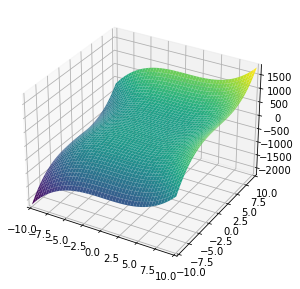

In [50]:
length = 10
plot3d(x*x*x-x*x-x+y*y*y-y*y-y, (x, -length, length), (y, -length, length))

In [51]:
def newton(f,Df,x0,epsilon,max_iter):
    '''Approximate solution of f(x)=0 by Newton's method.

    Parameters
    ----------
    f : function
        Function for which we are searching for a solution f(x)=0.
    Df : function
        Derivative of f(x).
    x0 : number
        Initial guess for a solution f(x)=0.
    epsilon : number
        Stopping criteria is abs(f(x)) < epsilon.
    max_iter : integer
        Maximum number of iterations of Newton's method.

    Returns
    -------
    xn : number
        Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> Df = lambda x: 2*x - 1
    >>> newton(f,Df,1,1e-8,10)
    Found solution after 5 iterations.
    1.618033988749989
    '''
    xn = x0
    for n in range(max_iter):
        fxn = f(xn)
        if abs(fxn) < epsilon:
            print('Found solution after',n,'iterations.')
            return xn
        Dfxn = Df(xn)
        if Dfxn == 0:
            print('Zero derivative. No solution found.')
            return None
        xn = xn - fxn/Dfxn
    print('Exceeded maximum iterations. No solution found.')
    return None

In [59]:
f  = lambda x: x**3-x-1
df = lambda x: 3*x**2-1
approx = newton(f,df,2,1e-10,6)

Found solution after 5 iterations.


In [60]:
approx

1.3247179572458576